<a href="https://colab.research.google.com/github/ryo1021/OCR/blob/main/theme_B_visual_structure/ocr_baseline/tesseract_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract pillow
!apt-get install -y tesseract-ocr-jpn


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,902 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,468 kB]


In [ ]:
import pytesseract
from PIL import Image
import json

img = Image.open('/content/スクリーンショット 2026-02-07 173412.png')

data = pytesseract.image_to_data(
    img,
    lang='jpn',
    config='--psm 6',
    output_type=pytesseract.Output.DICT
)


In [11]:
import cv2, numpy as np, json
from PIL import Image

img_path = "/home/スクリーンショット 2026-01-14 174845.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 1) 二値化（手書きなら適応二値化が無難）
bin_img = cv2.adaptiveThreshold(
    img, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# 2) 小ノイズ除去（点を消しすぎない程度）
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# 3) 連結成分（文字の塊）を抽出
num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []
H, W = bin_img.shape

for i in range(1, num):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # フィルタ（ここは後で調整）
    if area < 8:      # 小さすぎるノイズ除外（点は残したいので低め）
        continue
    if w > 0.9*W or h > 0.9*H:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area),
        "text_candidates": []  # ←ここに後で候補を入れる
    })

out = {"image": img_path, "num_elements": len(elements), "elements": elements}
with open("/content/min_units.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

print("最小単位候補数:", len(elements))


最小単位候補数: 360


In [5]:
import cv2
import numpy as np
import json
from PIL import Image, ImageDraw, ImageFont

# ===== 画像パス =====
img_path = "/home/スクリーンショット 2026-01-14 174845.png"

# ===== 読み込み =====
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===== 二値化（手書き用）=====
bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# ===== 小ノイズ除去 =====
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# ===== 連結成分抽出 =====
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []

H, W = bin_img.shape

for i in range(1, num_labels):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # ノイズ除去条件（緩め）
    if area < 10:
        continue
    if w < 2 or h < 2:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area)
    })

print("最小単位数:", len(elements))

# ===== 可視化 =====
pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(pil_img)

for e in elements:
    x, y, w, h = e["bbox"]
    draw.rectangle(
        [(x, y), (x + w, y + h)],
        outline="red",
        width=2
    )
    draw.text((x, y-10), str(e["id"]), fill="blue")

out_path = "/content/min_units_overlay.png"
pil_img.save(out_path)

# 普通サイズを基準にする
heights = [e["bbox"][3] for e in elements]
avg_height = sum(heights) / len(heights)

sup_candidates = []

for e_small in elements:
    w, h = e_small["bbox"][2], e_small["bbox"][3]

    if w < 10 and h < 10:  # 小さい塊

        sx, sy = e_small["center"]

        for e_big in elements:
            bw, bh = e_big["bbox"][2], e_big["bbox"][3]

            if bw >= 10 and bh >= 10:  # 普通サイズ

                bx, by = e_big["center"]

                # 厳しめ条件
                if (
                    sy < by - 0.35 * bh and          # しっかり上に
                    sx > bx and                     # 右側
                    sx - bx < 0.8 * bw and          # 近い
                    h < 0.8 * bh                    # 小さい
                ):
                    sup_candidates.append((e_small["id"], e_big["id"]))

print("上付き候補数:", len(sup_candidates))
sup_candidates[:10]





error: OpenCV(4.13.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [6]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# ===== 画像パス =====
img_path = "/home/スクリーンショット 2026-01-14 174845.png"

# ===== 読み込み =====
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===== 二値化 =====
bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# ===== ノイズ軽減 =====
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# ===== 連結成分抽出 =====
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []

for i in range(1, num_labels):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    if area < 10:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area)
    })

print("最小単位数:", len(elements))


最小単位数: 300


In [7]:
scored_sup = []

for e_small in elements:
    w, h = e_small["bbox"][2], e_small["bbox"][3]

    # 小さい塊のみ
    if w < 10 and h < 10:
        sx, sy = e_small["center"]

        for e_big in elements:
            bw, bh = e_big["bbox"][2], e_big["bbox"][3]

            # 基本文字候補
            if bw >= 10 and bh >= 10:
                bx, by = e_big["center"]

                if sy < by and sx > bx:
                    height_score = (by - sy) / bh
                    right_score = (sx - bx) / bw
                    size_score = (bh - h) / bh

                    total_score = height_score + right_score + size_score

                    scored_sup.append({
                        "small": e_small["id"],
                        "big": e_big["id"],
                        "score": round(total_score, 3)
                    })

# スコア順に並べる
scored_sup = sorted(scored_sup, key=lambda x: -x["score"])

print("上付き候補数:", len(scored_sup))
print("上位5件:", scored_sup[:5])


上付き候補数: 1995
上位5件: [{'small': 55, 'big': 130, 'score': 96.589}, {'small': 55, 'big': 182, 'score': 94.07}, {'small': 16, 'big': 130, 'score': 93.168}, {'small': 43, 'big': 130, 'score': 91.106}, {'small': 16, 'big': 182, 'score': 90.926}]


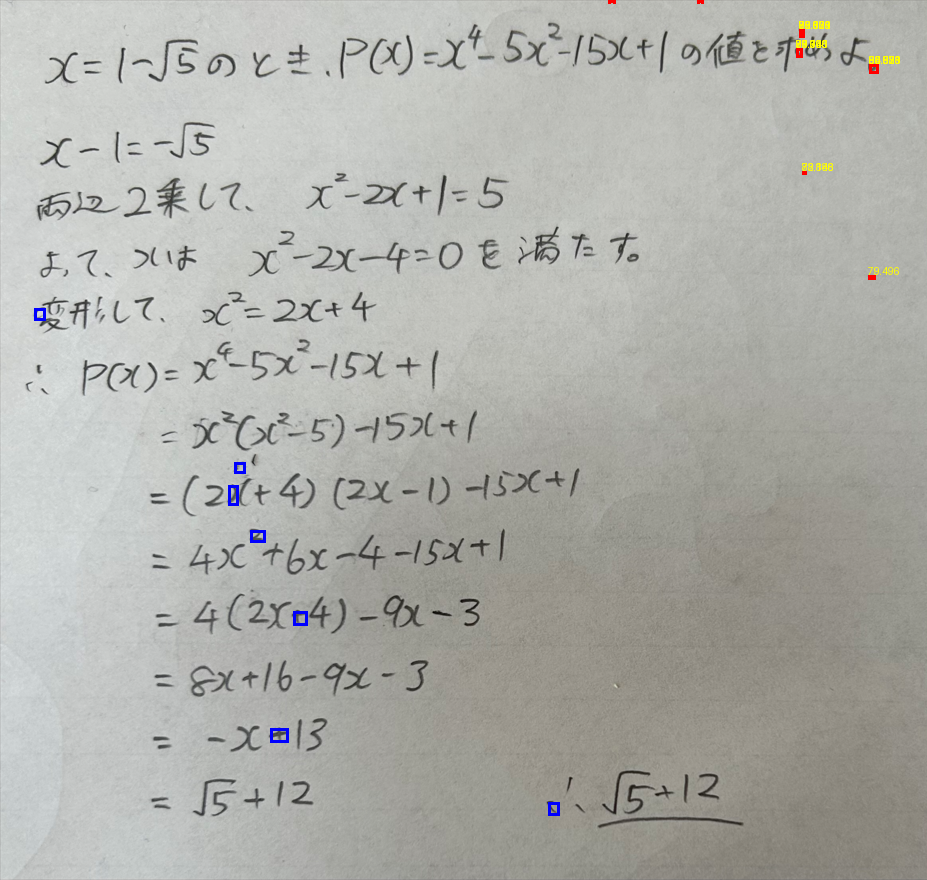

In [8]:
orig_img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(orig_img)

top_k = 30

for item in scored_sup[:top_k]:
    small_id = item["small"]
    big_id = item["big"]
    score = item["score"]

    small = elements[small_id]
    big = elements[big_id]

    sx, sy, sw, sh = small["bbox"]
    bx, by, bw, bh = big["bbox"]

    # 上付き候補（赤）
    draw.rectangle([(sx, sy), (sx+sw, sy+sh)], outline="red", width=3)

    # 基準文字（青）
    draw.rectangle([(bx, by), (bx+bw, by+bh)], outline="blue", width=3)

    draw.text((sx, sy-10), str(score), fill="yellow")

display(orig_img)
